In [2]:
import sys, os
sys.path.insert(1, 'D:/LAB/CAPTCHA/base_solver/base_solver_char')
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import torchvision.transforms as transforms
import captcha_setting
import my_dataset
from captcha_cnn_model import CNN, Generator
import cv2 as cv
from matplotlib import pyplot as plt

from PIL import Image
import copy
import operator

#for eachimg in filter_containor:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear((captcha_setting.IMAGE_WIDTH//8)*(captcha_setting.IMAGE_HEIGHT//8)*64, 1024),
            nn.Dropout(0.1),  # drop 50% of the neuron
            nn.ReLU())
        self.rfc = nn.Sequential(
            nn.Linear(1024, 256),#captcha_setting.MAX_CAPTCHA*captcha_setting.ALL_CHAR_SET_LEN),
            nn.ReLU()
        )
        self.rfc2 = nn.Sequential(
            nn.Linear(256, 36),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        #print(out.shape)
        out = self.rfc(out)
        out = self.rfc2(out)
        #out = out.view(out.size(0), -1)
        #print(out.shape)
        return out
def calculate_corner_border(thresh, nrootdir="cut_image/"):
    show_img = cv.imread('temp.jpg')
    contours,hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
#     print(contours[0])
    new_contours = []
    cur_contours = []
    filter_containor = []
    for i in contours:
        #print(i)
        x, y, w, h = cv.boundingRect(i)   
        cur_contours.append([x, y, w, h])
        contours = sorted(cur_contours, key=operator.itemgetter(0))
    for i in range(0,len(contours)):  
        x = contours[i][0]
        y = contours[i][1]
        w = contours[i][2] 
        h = contours[i][3]
        #= cv.boundingRect(contours[i])   
        newimage=thresh[y:y+h,x:x+w] # 先用y确定高，再用x确定宽
        nrootdir=("cut_image/")
        if h*w<25:
            continue
        color = [255, 255, 255]
        top, bottom, left, right = [1]*4

        newimage = cv.copyMakeBorder(newimage, top, bottom, left, right, cv.BORDER_CONSTANT, value=color)
        #newimage = 
        newimage = cv.resize(newimage,(30, 60), interpolation = cv.INTER_CUBIC)
        #filter_containor.append(newimage)

#         cv.rectangle(temp_img, (x,y), (x+w,y+h), (153,153,0), 1)
        if not os.path.isdir(nrootdir):
            os.makedirs(nrootdir)
        cv.imwrite( nrootdir+str(i)+".jpg",newimage)
        cv.imwrite( "temp1.jpg",newimage) 
        filter_containor.append(Image.open("temp1.jpg"))
    return filter_containor

def calculate_corner_seg(thresh, nrootdir="cut_image/"):
    show_img = cv.imread('temp.jpg')
    contours,hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
#     print(contours[0])
    new_contours = []
    cur_contours = []
    filter_containor = []
    for i in contours:
        #print(i)
        x, y, w, h = cv.boundingRect(i)   
        cur_contours.append([x, y, w, h])
    contours = sorted(cur_contours, key=operator.itemgetter(0))
    for i in range(0,len(contours)):  
        x = contours[i][0]
        y = contours[i][1]
        w = contours[i][2] 
        h = contours[i][3]
        newimage=thresh[y:y+h,x:x+w] # 先用y确定高，再用x确定宽
        nrootdir=("cut_image/")
        if (h*w<25):
            continue
#         print(contours[i])
#         cv.rectangle(show_img, (x,y), (x+w,y+h), (153,153,0), 1)
        new_contours.append(contours[i])
    t0 = [i[0] for i in new_contours]
    t1 = [i[1] for i in new_contours]
    t2 = [i[2] for i in new_contours]
    t3 = [i[3] for i in new_contours]
    x_max = max([new_contours[i][0] + new_contours[i][2] for i in range(len(new_contours))] )+5
    x_min = min(t0)-5
    y_max = 59#max([new_contours[i][1] + new_contours[i][3] for i in range(len(new_contours))] )
    y_min = 0#min(t1)
    if(x_min<0):
        x_min = 0
    if(x_max>159):
        x_max = 159
    width = (x_max-x_min)//5
    for i in range(0,5):
#         cv.rectangle(show_img, (x_min+i*width,y_min), (x_min+(i+1)*width,y_max), (153,153,0), 1)
        newimage=thresh[y_min:y_max,x_min+i*width:x_min+(i+1)*width]
        top, bottom, left, right = [1]*4
        newimage = cv.copyMakeBorder(newimage, top, bottom, left, right, cv.BORDER_CONSTANT)
        newimage = cv.resize(newimage,(30, 60), interpolation = cv.INTER_CUBIC)
        cv.imwrite( "temp1.jpg",newimage)
        filter_containor.append(Image.open("temp1.jpg"))
#     return x_max,x_min,y_max,y_min
#     plt.imshow(show_img)
#     plt.show()
    return filter_containor

def calculate_corner(thresh, nrootdir="cut_image/"):
    show_img = cv.imread('temp.jpg')
#     im2,contours,hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
#     print(contours[0])
    new_contours = []
    cur_contours = []
    filter_containor = []
#     for i in contours:
#         #print(i)
#         x, y, w, h = cv.boundingRect(i)   
#         cur_contours.append([x, y, w, h])
#     contours = sorted(cur_contours, key=operator.itemgetter(0))
#     for i in range(0,len(contours)):  
#         x = contours[i][0]
#         y = contours[i][1]
#         w = contours[i][2] 
#         h = contours[i][3]
#         newimage=thresh[y:y+h,x:x+w] # 先用y确定高，再用x确定宽
#         nrootdir=("cut_image/")
#         if (h<8) or (h*w<80) or (h*w >4000):
#             continue
#         print(contours[i])
#         cv.rectangle(show_img, (x,y), (x+w,y+h), (153,153,0), 1)
#         new_contours.append(contours[i])
    x_max = 100 #135
    x_min = 0 #25
    y_max = 59#50
    y_min = 0#10
    width = (x_max-x_min)//5
    for i in range(0,5):
#         cv.rectangle(show_img, (x_min+i*width,y_min), (x_min+(i+1)*width,y_max), (153,153,0), 1)
        newimage=thresh[y_min:y_max,x_min+i*width:x_min+(i+1)*width]
        top, bottom, left, right = [1]*4
        newimage = cv.copyMakeBorder(newimage, top, bottom, left, right, cv.BORDER_CONSTANT)
        newimage = cv.resize(newimage,(30, 60), interpolation = cv.INTER_CUBIC)
        cv.imwrite( "temp.jpg",newimage)
        filter_containor.append(Image.open("temp.jpg"))
#     return x_max,x_min,y_max,y_min
#     plt.imshow(show_img)
#     plt.show()
    return filter_containor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN()
cnn.eval()
cnn.load_state_dict(torch.load('./model_lake/yellow_char_4.pkl'))
cnn.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

load GAN net.
('06h9u_8551.png',)


<ipython-input-3-22497113b813>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs).float()


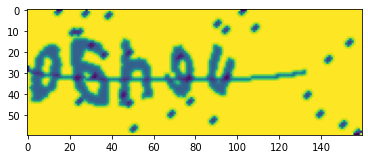

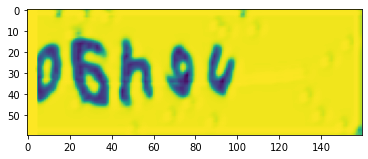

In [3]:
label = ''
def gaussian_blur(img):
    image = np.array(img)
    image_blur = cv.GaussianBlur(image,(5,5),0)
    new_image = image_blur
    return new_image
class testdataset(Dataset):

    def __init__(self, folder, transform=None):
        self.train_image_file_paths = [os.path.join(folder, image_file) for image_file in os.listdir(folder)]
        self.transform = transform

    def __len__(self):
        return len(self.train_image_file_paths)

    def __getitem__(self, idx):
        image_root = self.train_image_file_paths[idx]
        image_name = image_root.split(os.path.sep)[-1]
        image = Image.open(image_root)
        image = image.resize((160,60), Image.ANTIALIAS)
        label = image_name
        #label = ohe.encode(image_name.split('_')[0]) # 为了方便，在生成图片的时候，图片文件的命名格式 "4个数字或者数字_时间戳.PNG", 4个字母或者即是图片的验证码的值，字母大写,同时对该值做 one-hot 处理
        if self.transform is not None:
            image = self.transform(image)
            #label = self.transform(label)
        #label = ohe.encode(image_name.split('_')[0])
        return image, label
transform_1 = transforms.Compose([
    # transforms.ColorJitter(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_path = "D:/LAB/CAPTCHA/dataset_2.0/len_5_train"
def get_loader():
    dataset = testdataset(img_path, transform=transform_1)
    return DataLoader(dataset, batch_size=1, shuffle=False)
dataloader = get_loader()

generator = Generator()
generator.load_state_dict(torch.load('D:/LAB/CAPTCHA/base_solver/base_solver_char/7800.pkl'))
generator.eval()
print("load GAN net.")
# img = cv.imread(img_path+"33.png")


label_target = ""
for i, (imgs, label) in enumerate(dataloader):
#     plt.imshow(imgs[0][0])
#     plt.show()
    if(i<15):
        continue
    print(label)
    label_target = label
#     imgs = Image.open('new_captcha.png')
#     imgs = imgs.resize((160,60), Image.ANTIALIAS)
#     plt.imshow(imgs)
#     plt.show()
#     imgs = transform(imgs)
    imgs = torch.tensor(imgs).float()
    new_img = generator(imgs)
    new_img2 = new_img.data.cpu().numpy()
    imgs2 = imgs.data.cpu().numpy()
#     print(new_img2.shape)
#     print(label)
    imgs2 = imgs2[0][0]
    imgs2 = imgs2*255
    target_img = new_img2[0][0]
#     plt.imshow(new_img2[0][0])
#     plt.show()
    target_img = target_img*255
    #print()
#    gray = cv.cvtColor(target_img,cv.COLOR_BGR2GRAY)
#    ret, thresh = cv.threshold(target_img,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    cv.imwrite( "temp.jpg",imgs2)
    cv.imwrite( "temp_2.jpg",target_img)
    plt.imshow(imgs2)
    plt.show()
    plt.imshow(target_img)
    plt.show()
#     save_image(thresh, "/home/ning_a/Desktop/CAPTCHA/Solving_CAPTCHA_GAN_CNN/seged_rescator_clean/%s.png" % 
#                label[0].split('.')[0], nrow=1, normalize=True)
    break
#     if(i>0):
#         break

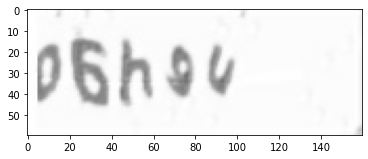

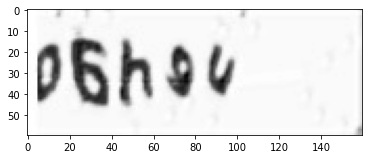

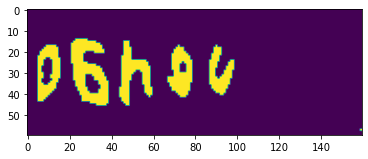

In [4]:
# img = cv.imread("8.png")
# img = cv.imread('new_captcha.png')
# img = Image.open('new_captcha.png')
img = cv.imread('temp.jpg')
img_t = cv.imread('temp_2.jpg')
img = img_t
# img = 255-img
plt.imshow(img)
plt.show()
#print(target_img)
threshold = 5  
# img = img.point(lambda p: p > threshold and 255)
# img = np.array(img)
n_img = np.zeros((img.shape[0],img.shape[1]))
img_aft = cv.normalize(img, n_img, 0,255,cv.NORM_MINMAX)
plt.imshow(img_aft)
plt.show()
gray = cv.cvtColor(img_aft,cv.COLOR_BGR2GRAY)
# gray = g
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
# ret, thresh_reverse = cv.threshold(img_aft,0,255,cv.THRESH_OTSU)
# thresh = 255-thresh
plt.imshow(thresh)
plt.show()

In [5]:
# print(type(target_img))


# filter_containor = calculate_corner_border(thresh)
filter_containor = calculate_corner(thresh)
# for each_img in filter_containor:
#     print(each_img)
#     plt.imshow(each_img)
#     plt.show()

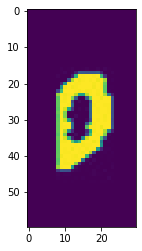

torch.Size([1, 1, 60, 30])


<ipython-input-6-cbaf76e05c64>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, device=device).float()


n


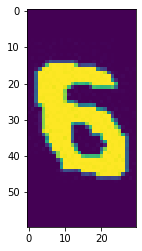

torch.Size([1, 1, 60, 30])
s


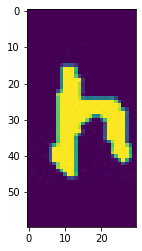

torch.Size([1, 1, 60, 30])
r


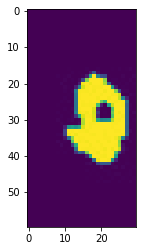

torch.Size([1, 1, 60, 30])
a


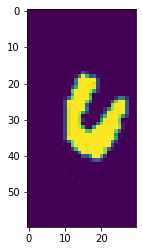

torch.Size([1, 1, 60, 30])
4


In [6]:
transform = transforms.Compose([
    # transforms.ColorJitter(),
    transforms.Grayscale(),
#     transforms.Lambda(gaussian_blur),
    transforms.ToTensor()
])
label_predicted = ""
for eachimg in filter_containor:
    #print(eachimg)
    image = transform(eachimg).unsqueeze(0)
    plt.imshow(eachimg)
    plt.show()
    print(image.shape)
    
    image = torch.tensor(image, device=device).float()
    image = Variable(image).to(device)
    #print(image.shape)
#     image, labels =  image.to(device), labels.to(device)
    # vimage = generator(image)
    predict_label = cnn(image)
    #labels = labels.cpu()
    predict_label = predict_label.cpu()
    _, predicted = torch.max(predict_label, 1)
    print(captcha_setting.ALL_CHAR_SET[predicted])
    label_predicted += captcha_setting.ALL_CHAR_SET[predicted]

In [35]:
label_predicted

'wxhnh'

TypeError: Image data cannot be converted to float

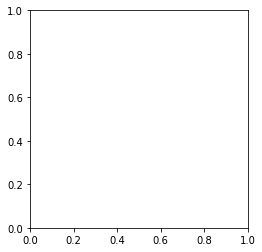

In [13]:
img = cv.imread('/home/ning_a/Desktop/CAPTCHA/Solving_CAPTCHA_GAN_CNN/seged_rescator/245.png')
#ret, thresh = cv.threshold(test_img,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
#ret, thresh = cv.threshold(gray,0,255,cv.THRESH_OTSU)
plt.imshow(img)
plt.show()

# dataset making for seg

In [19]:
file_path = "D:/LAB/CAPTCHA/dataset_2.0/len_5_test/"
save_path = "D:/LAB/CAPTCHA/dataset_ablation/5_test_interval/"
transform = transforms.Compose([
    # transforms.ColorJitter(),
    transforms.Grayscale(),
#     transforms.Lambda(gaussian_blur),
    transforms.ToTensor()
])
if(not os.path.exists(save_path)):
    os.mkdir(save_path)
llist = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,
        'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'J':0,'K':0,'L':0,'M':0,
         'N':0,'O':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'U':0,'V':0,'W':0,'X':0,'Y':0,'Z':0}
test_img_list = os.listdir(file_path)
for img_name in test_img_list:
    if('_' in img_name):
        label = img_name.split('_')[0].upper()
    else:
        label = img_name.split('.')[0].upper()
    #using GAN
    image = Image.open(file_path+img_name)
    image = image.resize((160,60), Image.ANTIALIAS)
    image = transform(image)
    
    imgs = torch.tensor(image).float()
    new_img = generator(imgs)
    new_img2 = new_img.data.cpu().numpy()
    imgs2 = imgs.data.cpu().numpy()
    imgs2 = imgs2[0][0]
    imgs2 = imgs2*255
    target_img = new_img2[0][0]
    target_img = target_img*255
    im = Image.fromarray(target_img)
    im = im.convert('RGB')
    im.save('temp.png')
    img = cv.imread('temp.png')
    # end using GAN

    img = cv.resize(img,(160, 60), interpolation = cv.INTER_CUBIC)
    img_aft = cv.normalize(img, n_img, 0,255,cv.NORM_MINMAX)
    gray = cv.cvtColor(img_aft,cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    filter_containor = calculate_corner(thresh)
#     filter_containor = calculate_corner_border(thresh)
#     filter_containor = calculate_corner_seg(thresh)
    for i in range(0,5):
        try:
            if(not os.path.exists(save_path+label[i])):
                os.mkdir(save_path+label[i])
            filter_containor[i].save( save_path+label[i]+'/'+str(llist[label[i]])+'.png')
            llist[label[i]] += 1
        except:
            break

<ipython-input-19-f136f6270fbd>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(image).float()


# Go Through All Test Data

In [9]:
file_path = "D:/LAB/CAPTCHA/dataset_2.0/len_5_test/"
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])
llist = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,
        'A':0,'B':0,'C':0,'D':0,'E':0,'F':0,'G':0,'H':0,'I':0,'J':0,'K':0,'L':0,'M':0,
         'N':0,'O':0,'P':0,'Q':0,'R':0,'S':0,'T':0,'U':0,'V':0,'W':0,'X':0,'Y':0,'Z':0}
test_img_list = os.listdir(file_path)
final_score = 0
for i in range(0,5):
    total = 0
    correct = 0
    cnn = CNN()
    cnn.eval()
    model_path = 'D:/LAB/CAPTCHA/base_solver/base_solver_char/model_lake/ex22_5_interval_'+str(i)+'.pkl'
    cnn.load_state_dict(torch.load(model_path))
    cnn.to(device)

    for img_name in test_img_list:
        total += 1
        if('_' in img_name):
            label = img_name.split('_')[0].upper()
        else:
            label = img_name.split('.')[0].upper()

        #using GAN
        image = Image.open(file_path+img_name)
        image = image.resize((160,60), Image.ANTIALIAS)
        image = transform(image)

        imgs = torch.tensor(image).float()
        new_img = generator(imgs)
        new_img2 = new_img.data.cpu().numpy()
        imgs2 = imgs.data.cpu().numpy()
        imgs2 = imgs2[0][0]
        imgs2 = imgs2*255
        target_img = new_img2[0][0]
        target_img = target_img*255
        im = Image.fromarray(target_img)
        im = im.convert('RGB')
        im.save('temp.png')
        img = cv.imread('temp.png')
        # end using GAN        




    #     img = cv.imread(file_path+img_name)
        img = cv.resize(img,(160, 60), interpolation = cv.INTER_CUBIC)
        img_aft = cv.normalize(img, n_img, 0,255,cv.NORM_MINMAX)
        gray = cv.cvtColor(img_aft,cv.COLOR_BGR2GRAY)
        ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
        try:
            filter_containor = calculate_corner(thresh)
#             filter_containor = calculate_corner_border(thresh)
#             filter_containor = calculate_corner_seg(thresh)
        except:
            continue
        p_lable = ''
        for i in range(0,5):
            try:
                image = transform(filter_containor[i]).unsqueeze(0)
                image = torch.tensor(image, device=device).float()
                image = Variable(image).to(device)
                predict_label = cnn(image)
                predict_label = predict_label.cpu()
                _, predicted = torch.max(predict_label, 1)
        #         print(captcha_setting.ALL_CHAR_SET[predicted])
                p_lable += captcha_setting.ALL_CHAR_SET[predicted]
        #         label_predicted += captcha_setting.ALL_CHAR_SET[predicted]
            
            except:
                break
#         print(p_lable,label)
        if(p_lable.upper() == label.upper()):
            correct += 1
    print(correct)
#     print(total)
#     print(float(correct/total))
    final_score += float(correct/total)
#     print(final_score)
print('final_score:',final_score/5)
#     break

<ipython-input-9-b75c542d8ecc>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(image).float()
<ipython-input-9-b75c542d8ecc>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, device=device).float()


735
719
741
733
731
final_score: 0.731068931068931
